<a href="https://colab.research.google.com/github/paulyu8868/test/blob/main/%EC%B9%A8%EB%AA%B0%EB%B0%A9%EC%A7%80%EB%B2%95v1_3_1(%EB%B3%B5%EB%A6%AC%2B%EC%B0%A8%ED%8A%B8%EB%B6%84%EC%84%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dataclasses import dataclass


import warnings
# 모든 FutureWarning 무시
warnings.filterwarnings('ignore', category=FutureWarning)
# UserWarning도 무시
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
#기간별 주가 데이터 불러오기
def get_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df.drop(columns=['Volume', 'Adj Close'])
    df.index = df.index.date

    # 호가 단위 0.01$ 적용
    for col in ['Open', 'High', 'Low', 'Close']: # 시가,고가,저가,종가
        df[col] = df[col].map(round_half_up_to_two)

    # 등락율 계산
    df['Return'] = df['Close'].pct_change()
    df['Return'] = df['Return'].map(pointTopercent)
    #df['Return'] = df['Return'].map(round_half_up_to_two)

    return df

In [3]:
# 소수 셋째자리에서 반올림
def round_half_up_to_two(num):
    try:
        if isinstance(num, (float, int)):
            num_100 = num * 100
            if num_100 - int(num_100) >= 0.5:
                return (int(num_100) + 1) / 100
            else:
                return int(num_100) / 100
        else:
            return num
    except:
        return num

# 퍼센트로 변환
def pointTopercent(num):
    return round_half_up_to_two(num*100)

In [4]:
def calculate_mdd(equity_curve):
    """MDD(Maximum Drawdown) 계산"""
    cummax = equity_curve.cummax()
    drawdown = (equity_curve - cummax) / cummax * 100
    mdd = drawdown.min()
    return mdd

In [37]:
# 침몰방지법 매매로직
def infinite_buy_simulation(df, df_res, initial_funds, buy_portion, start_idx, simulation_period,welfare):
    funds = initial_funds # 초기 자금
    final_value = initial_funds # 총 평가액
    one_buy_amount = initial_funds / buy_portion # 회차별 매수금액
    holdings = 0 # 보유 주식 수
    buy_records = []  # 각 매수 건을 저장하여 관리 (개별 매도 관리)
    trade_history = []  # 매도 기록 저장
    trade_id = 1  # 매수 회차별 ID (매수 구분)

    T=0 # T값 = 보유 회차 수

    # 날짜별 거래기록 데이터 프레임
    df_res = pd.DataFrame(index=range(start_idx, start_idx + simulation_period + 1),
                         columns=['날짜', '시가', '고가', '종가', '등락율',
                                'LOC 매수', '수익 실현 매도', 'MOC 손절',
                                '보유 주식 수', '예수금', '총 평가액', '수익율(%)'])

    # 시작일 - 종료일 시뮬레이션 진행
    for i in range(start_idx, start_idx + simulation_period + 1):
        # 데이터 시리즈로 가져오기
        current_date = df.index[i]
        open_price = float(df['Open'].iloc[i]) #시가
        high_price = float(df['High'].iloc[i]) #고가
        close_price = float(df['Close'].iloc[i]) #종가
        return_val = float(df['Return'].iloc[i]) #등락율
        prev_price = float(df['Close'].iloc[i-1]) if i > 0 else close_price #전날 종가


        # 오늘 데이터
        df_res.at[i, '날짜'] = current_date
        df_res.at[i, '시가'] = open_price
        df_res.at[i, '고가'] = high_price
        df_res.at[i, '종가'] = close_price
        df_res.at[i, '등락율'] = f"{round_half_up_to_two(return_val)}%"

        # 당일 종가
        price = close_price

        # 매수/매도 칼럼 초기화
        df_res.at[i, 'LOC 매수'] = 0
        df_res.at[i, '수익 실현 매도'] = 0
        df_res.at[i, 'MOC 손절'] = 0

        '''
        *매매로직*
        매수 : (5-maximumT)%
        매도 : (10.5-2*maximumT)%
        최대보유기간 : (30-3*maximumT)일
        maximumT = min(T,5)
        '''
        maximumT=min(T,5) # T값 최대 5까지 적용
        start_T=T # 매매체결전 기준 T값 (해당일에 실제 적용되는 T값)
        loc_buy = (1.05-0.01*maximumT) # 매수 기준
        loc_sell = (1.105-0.02*maximumT) # 매도 기준
        '''
        *복리*
        복리적용 매수금액 = 예수금/(분할수-T)
        (T값이 분할수보다 작을때만 복리적용)
        '''
        one_buy_welfare = funds / (buy_portion-start_T) if start_T <= (buy_portion-1) else one_buy_amount # 복리
        #one_buy_welfare = final_value /buy_portion # 복리적용 매수금액 => 총평가액/분할수
        # 매수 로직
        if price <= prev_price*loc_buy: # 매수 기준
            if welfare: # 복리적용
                qty = int(one_buy_welfare / (prev_price * loc_buy)) # 복리적용 수량
            else:
                qty = int(one_buy_amount / (prev_price * loc_buy)) # 복리X 수량
            if funds >= qty * price:
                holdings += qty
                funds -= qty * price
                T +=1 # 회차수 +=1
                buy_records.append({
                    'id': trade_id,
                    'buy_date': current_date,
                    'buy_price': price,
                    'quantity': qty,
                    'days': 0,
                    'type': 'LOC 매수'
                })
                df_res.at[i, 'LOC 매수'] = qty
                trade_id += 1

        # 매도 로직
        if holdings > 0:
            new_buy_records = []  # 매도되지 않은 매수 건을 저장할 새 리스트
            total_sell = 0  # 당일 총 매도 수량

            for record in buy_records: # 보유 주식 순회
                record['days'] += 1  # 보유일 count
                # 각 매수 건별 매도 목표가
                sell_price = record['buy_price'] * loc_sell # 매도 기준

                if price >= sell_price:  # 수익 실현 매도 조건 충족
                    funds += record['quantity'] * price
                    total_sell += record['quantity']
                    holdings -= record['quantity']
                    T-=1 # 회차수 -=1

                    # 거래 기록 저장
                    trade_history.append({
                        '회차': record['id'],
                        '매수일': record['buy_date'],
                        '매수가': record['buy_price'],
                        '매수수량': record['quantity'],
                        '매도일': current_date,
                        '매도가': price,
                        '매도수량': record['quantity'],
                        '보유기간': record['days'],
                        '수익률(%)': round_half_up_to_two((price/record['buy_price'] - 1) * 100),
                        '적용 모드': "투자모드" if (maximumT)<5 else "회복모드",
                        '적용 T':start_T
                    })
                elif record['days'] >= (30-maximumT*3):  # 최대 보유일수 경과시 MOC 매도
                    funds += record['quantity'] * price
                    df_res.at[i, 'MOC 손절'] = record['quantity']
                    holdings -= record['quantity']
                    T-=1 # 회차수 -=1
                    # 손절 거래 기록 저장
                    trade_history.append({
                        '회차': record['id'],
                        '매수일': record['buy_date'],
                        '매수가': record['buy_price'],
                        '매수수량': record['quantity'],
                        '매도일': current_date,
                        '매도가': price,
                        '매도수량': record['quantity'],
                        '보유기간': record['days'],
                        '수익률(%)': (price/record['buy_price'] - 1) * 100,
                        '적용 모드': "투자모드" if (maximumT)<5 else "회복모드",
                        '적용 T':start_T
                    })
                else:
                    new_buy_records.append(record)

            if total_sell > 0:
                df_res.at[i, '수익 실현 매도'] = total_sell

            buy_records = new_buy_records

        # 포트폴리오 상태 저장
        final_value = funds + (holdings * price)
        df_res.at[i, '보유 주식 수'] = holdings
        df_res.at[i, '예수금'] = funds
        df_res.at[i, '총 평가액'] = final_value
        df_res.at[i, '수익율(%)'] = ((funds + (price * holdings)) / initial_funds - 1) * 100
        df_res.at[i, 'MDD'] = calculate_mdd(df_res['총 평가액'])
        df_res.at[i, 'T값'] = T
        df_res.at[i, '모드'] = "회복" if T>=5 else "투자"

    final_value = funds + (holdings * float(df['Close'].iloc[start_idx + simulation_period]))
    final_mdd = calculate_mdd(df_res['총 평가액'])
    return round_half_up_to_two((final_value / initial_funds - 1) * 100), df_res, final_value, pd.DataFrame(trade_history) , final_mdd

In [38]:
if __name__ == "__main__":
    start_date = '2021-01-01'
    end_date = '2021-12-31'
    initial_funds = 100000 # 초기 자금
    buy_portion = 10  # 회차 분할 수
    #welfare = False # 복리적용X
    welfare = True # 복리적용

    # 시작일
    start_date_dt = datetime.strptime(start_date,'%Y-%m-%d')

    # 종료일 다음 날 계산
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    next_day = end_date_dt + timedelta(days=1)
    end_day_next = next_day.strftime('%Y-%m-%d')

    # ticker 값으로 종목 선택 가능 ex) TQQQ
    df = get_data(ticker='TQQQ', start=start_date_dt, end=end_day_next)
    df_res = pd.DataFrame(columns=['날짜', '시가', '고가', '종가', '등락율', 'LOC 매수', '수익 실현 매도', 'MOC 손절',
                                  '보유 주식 수', '예수금', '총 평가액', '수익율(%)', 'MDD','T값',"모드"])

    # 시뮬레이션 실행
    return_rate, df_res, final_value, df_trades ,final_mdd= infinite_buy_simulation(
        df, df_res, initial_funds, buy_portion, 0, len(df)-1,welfare)

    # 매매 통계 출력
    print('\n' + '='*80)
    print("매매 통계")
    print('='*80)
    print(f"총 매매 횟수: {len(df_trades)} 회")
    print(f"평균 보유기간: {df_trades['보유기간'].mean():.1f} 일")
    print(f"평균 수익률: {df_trades['수익률(%)'].mean():.2f}%")
    win_rate = len(df_trades[df_trades['수익률(%)'] > 0]) / len(df_trades) * 100
    print(f"승률: {win_rate:.2f}%")

    print('\n' + '='*80)
    print(f"{start_date} ~ {end_date} 동안의 자산 변동 결과")
    print('='*80)
    print(f"최초 보유 금액: ${initial_funds:,.2f}")
    print(f"최종 보유 금액: ${final_value:,.2f}")
    print(f"원금 변화율: {return_rate}%")
    print(f"MDD : {final_mdd:.2f}%")
    print('='*80)


[*********************100%***********************]  1 of 1 completed



매매 통계
총 매매 횟수: 161 회
평균 보유기간: 6.7 일
평균 수익률: 1.23%
승률: 84.47%

2021-01-01 ~ 2021-12-31 동안의 자산 변동 결과
최초 보유 금액: $100,000.00
최종 보유 금액: $118,057.61
원금 변화율: 18.06%
MDD : -18.06%


In [32]:
# 날짜별 거래 현황 출력
print("\n[일별 거래 현황]")
df_res_style = df_res.style.format({
    '시가': '{:.2f}',
    '고가': '{:.2f}',
    '종가': '{:.2f}',
    'LOC 매수': '{:.0f}',
    '수익 실현 매도': '{:.0f}',
    'MOC 손절': '{:.0f}',
    '보유 주식 수': '{:.0f}',
    '예수금': '{:.2f}',
    '총 평가액': '{:.2f}',
    '수익율(%)': '{:.2f}',
    'MDD': '{:.2f}',
    'T값': '{:.0f}'
}).set_properties(**{'text-align': 'center'})
display(df_res_style)


[일별 거래 현황]


,날짜,시가,고가,종가,등락율,LOC 매수,수익 실현 매도,MOC 손절,보유 주식 수,예수금,총 평가액,수익율(%),MDD,T값,모드
0,2021-01-04,46.02,46.10,43.46,nan%,219,0,0,219,90482.26,100000.00,0.00,0.00,1,투자
1,2021-01-05,43.07,44.64,44.55,2.51%,224,0,0,443,80503.06,100238.71,0.24,0.00,2,투자
2,2021-01-06,42.47,44.58,42.71,-4.13%,223,0,0,666,70978.73,99423.59,-0.58,-0.81,3,투자
3,2021-01-07,43.84,46.16,45.79,7.21%,0,442,0,224,91217.91,101474.87,1.47,-0.81,1,투자
4,2021-01-08,46.83,47.72,47.57,3.89%,0,0,0,224,91217.91,101873.59,1.87,-0.81,1,투자
5,2021-01-11,46.20,46.74,45.47,-4.41%,206,0,0,430,81851.09,101403.19,1.40,-0.81,2,투자
6,2021-01-12,45.53,46.00,45.27,-0.43%,222,0,0,652,71801.15,101317.19,1.32,-0.81,3,투자
7,2021-01-13,45.39,46.55,46.15,1.94%,0,0,0,652,71801.15,101890.95,1.89,-0.81,3,투자
8,2021-01-14,46.38,46.83,45.45,-1.51%,224,0,0,876,61620.35,101434.55,1.43,-0.81,4,투자
9,2021-01-15,45.35,45.78,44.34,-2.44%,0,0,0,876,61620.35,100462.19,0.46,-1.40,4,투자


In [28]:
# 모든 매매 로그 출력
if not df_trades.empty:
    print("\n[매매 기록]")
    df_trades_style = df_trades.style.format({
        '매수가': '{:.2f}',
        '매수수량': '{:.0f}',
        '매도가': '{:.2f}',
        '매도수량': '{:.0f}',
        '수익률(%)': '{:.2f}',
        '적용 모드': '{:}',
        '적용 T': '{:.0f}'
    }).set_properties(**{'text-align': 'center'})

    # 수익률에 따른 색상 적용
    def color_returns(val):
        color = 'red' if val < 0 else ('blue' if val > 0 else 'black')
        return f'color: {color}'
    def mode_color(val):
        color = 'green' if val=="회복모드" else'black'
        return f'color: {color}'

    df_trades_style = df_trades_style.map(color_returns, subset=['수익률(%)'])
    df_trades_style = df_trades_style.map(mode_color, subset=['적용 모드'])
    display(df_trades_style)

    # 매매 통계 출력
    print('\n' + '='*80)
    print("매매 통계")
    print('='*80)
    print(f"총 매매 횟수: {len(df_trades)} 회")
    print(f"평균 보유기간: {df_trades['보유기간'].mean():.1f} 일")
    print(f"평균 수익률: {df_trades['수익률(%)'].mean():.2f}%")
    win_rate = len(df_trades[df_trades['수익률(%)'] > 0]) / len(df_trades) * 100
    print(f"승률: {win_rate:.2f}%")

    print('\n' + '='*80)
    print(f"{start_date} ~ {end_date} 동안의 자산 변동 결과")
    print('='*80)
    print(f"최초 보유 금액: ${initial_funds:,.2f}")
    print(f"최종 보유 금액: ${final_value:,.2f}")
    print(f"원금 변화율: {return_rate}%")
    print('='*80)


[매매 기록]


,회차,매수일,매수가,매수수량,매도일,매도가,매도수량,보유기간,수익률(%),적용 모드,적용 T
0,1,2021-01-04,43.46,219,2021-01-07,45.79,219,4,5.36,투자모드,3
1,3,2021-01-06,42.71,219,2021-01-07,45.79,219,2,7.21,투자모드,3
2,2,2021-01-05,44.55,222,2021-01-13,46.15,222,7,3.59,투자모드,4
3,5,2021-01-11,45.47,207,2021-01-19,46.26,207,6,1.74,회복모드,5
4,6,2021-01-12,45.27,221,2021-01-19,46.26,221,5,2.19,회복모드,5
5,7,2021-01-14,45.45,218,2021-01-19,46.26,218,3,1.78,회복모드,5
6,8,2021-01-15,44.34,225,2021-01-19,46.26,225,2,4.33,회복모드,5
7,4,2021-01-08,47.57,213,2021-01-25,51.65,213,11,8.58,투자모드,3
8,12,2021-01-27,47.54,198,2021-02-01,48.56,198,4,2.15,회복모드,5
9,13,2021-01-29,45.24,218,2021-02-01,48.56,218,2,7.34,회복모드,5



매매 통계
총 매매 횟수: 161 회
평균 보유기간: 6.7 일
평균 수익률: 1.23%
승률: 84.47%

2021-01-01 ~ 2021-12-31 동안의 자산 변동 결과
최초 보유 금액: $100,000.00
최종 보유 금액: $118,057.61
원금 변화율: 18.06%


<Figure size 1500x1000 with 0 Axes>

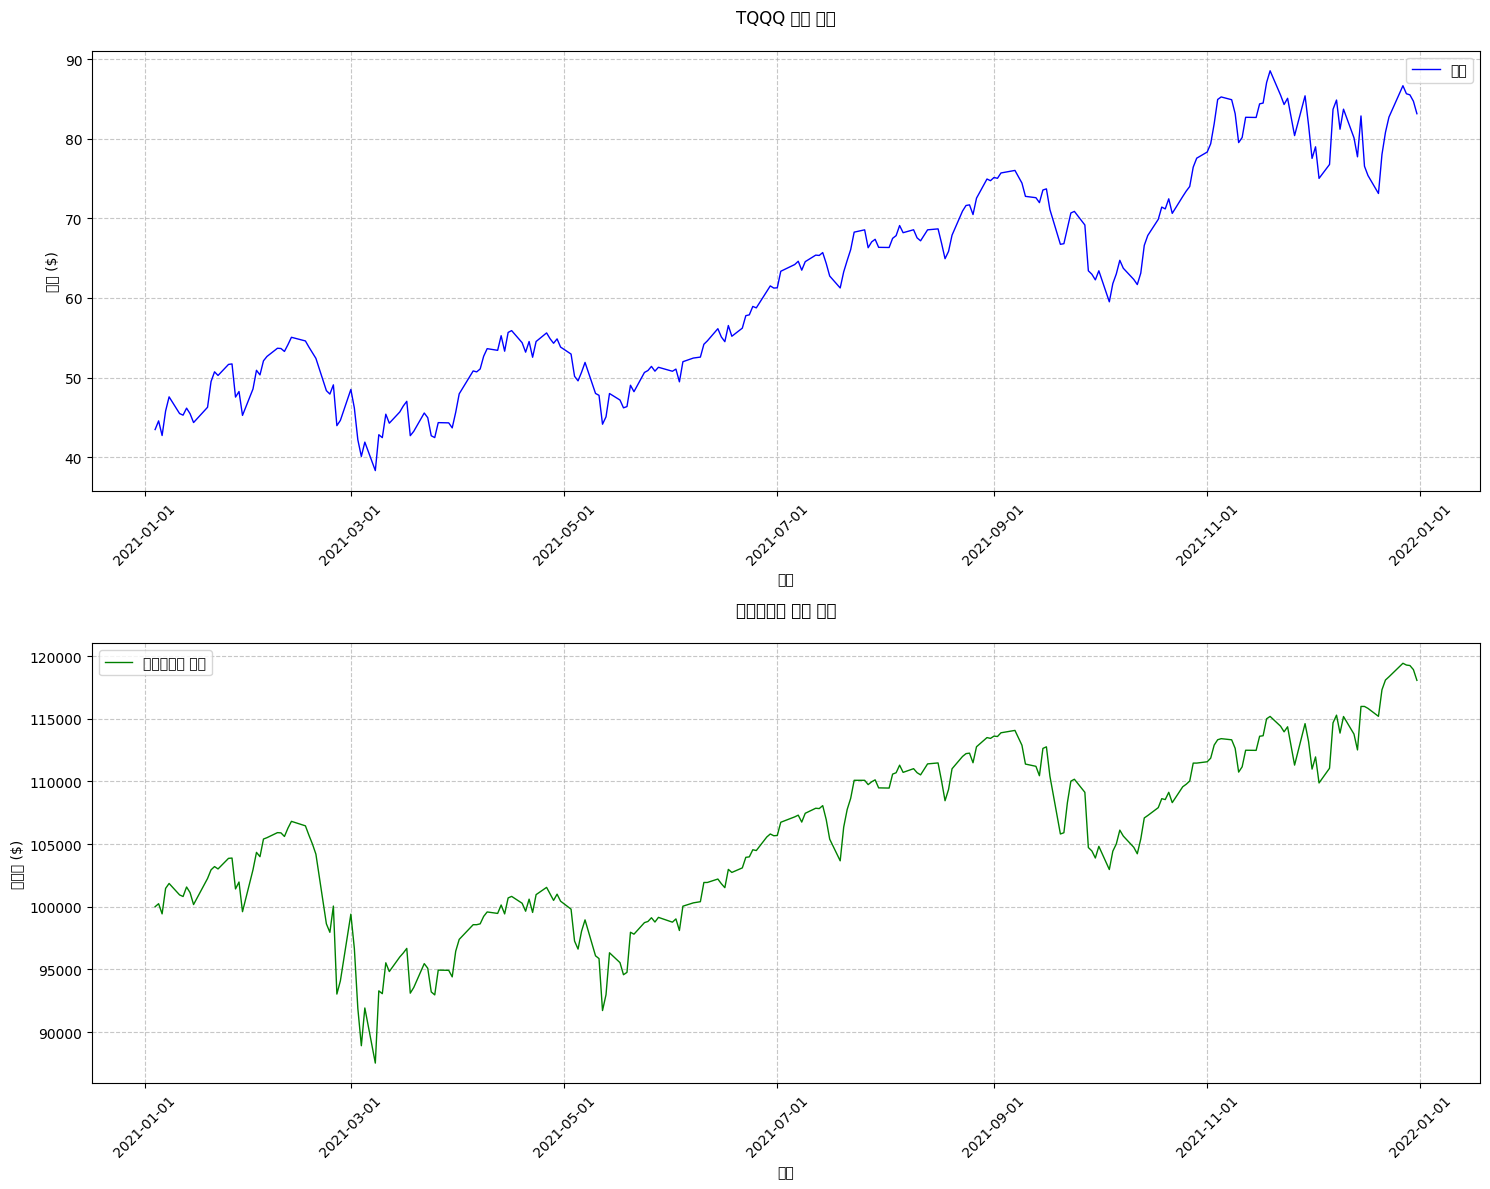

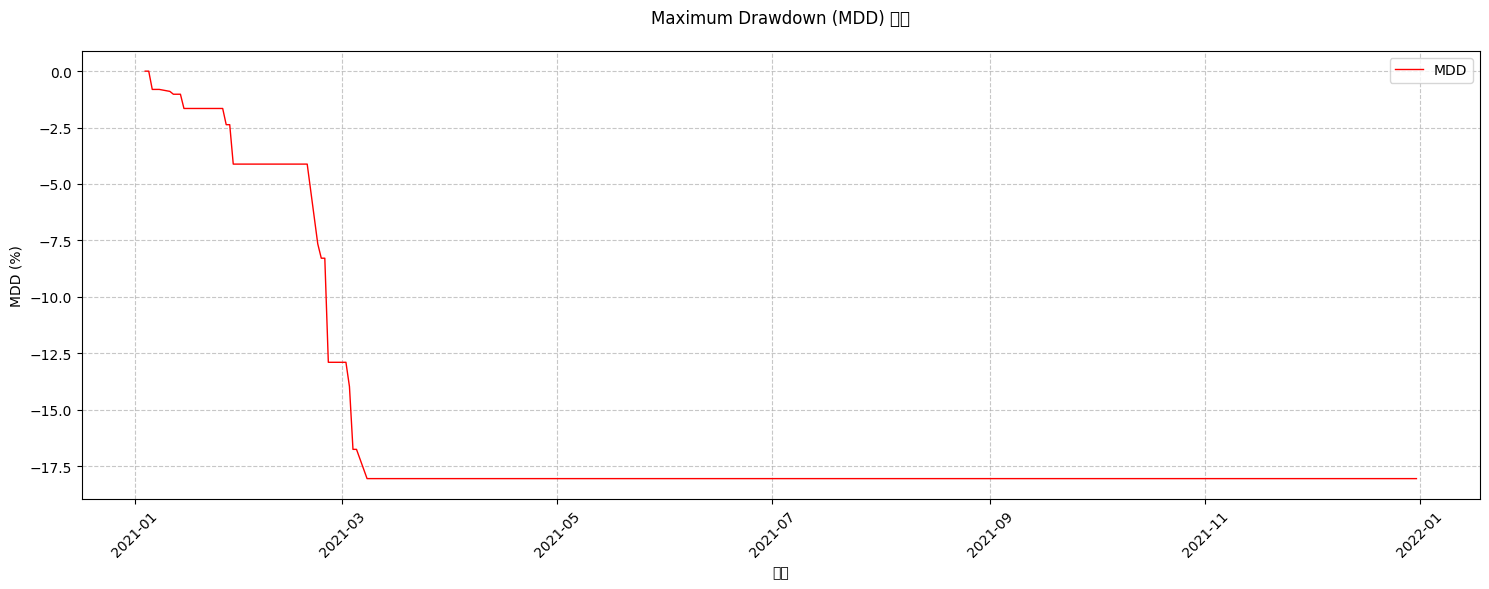

In [29]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 그래프 크기 설정
plt.figure(figsize=(15, 10))

# 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# TQQQ 가격 차트
ax1.plot(df.index, df['Close'], label='종가', color='blue', linewidth=1)
ax1.set_title('TQQQ 가격 추이', fontsize=12, pad=20)
ax1.set_xlabel('날짜', fontsize=10)
ax1.set_ylabel('가격 ($)', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=10)

# x축 날짜 포맷 설정
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 포트폴리오 가치 변화 차트
ax2.plot(df_res['날짜'], df_res['총 평가액'], label='포트폴리오 가치', color='green', linewidth=1)
ax2.set_title('포트폴리오 가치 변화', fontsize=12, pad=20)
ax2.set_xlabel('날짜', fontsize=10)
ax2.set_ylabel('평가액 ($)', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=10)

# x축 날짜 포맷 설정
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# MDD 시각화 (새로운 Figure 생성)
plt.figure(figsize=(15, 6))
mdd_series = df_res['MDD'].fillna(method='ffill')
plt.plot(df_res['날짜'], mdd_series, color='red', label='MDD', linewidth=1)
plt.title('Maximum Drawdown (MDD) 변화', fontsize=12, pad=20)
plt.xlabel('날짜', fontsize=10)
plt.ylabel('MDD (%)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()